c:\Users\mikoz\anaconda3\envs\CPO_env\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


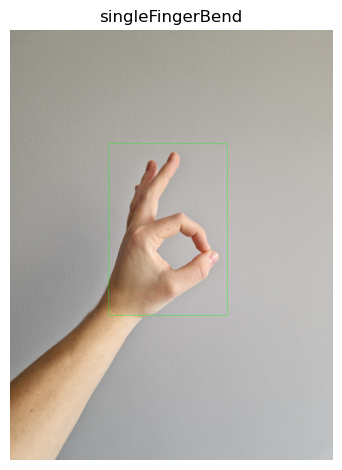

Center of hand: (1467, 1854)
Confidence: 0.3918


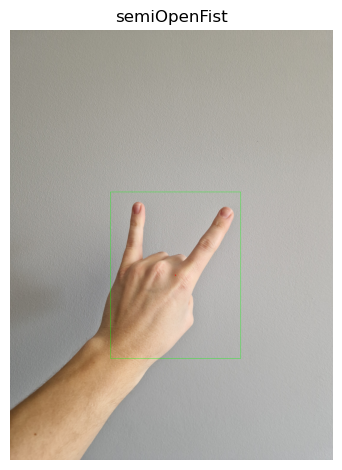

Center of hand: (1537, 2280)
Confidence: 0.6595


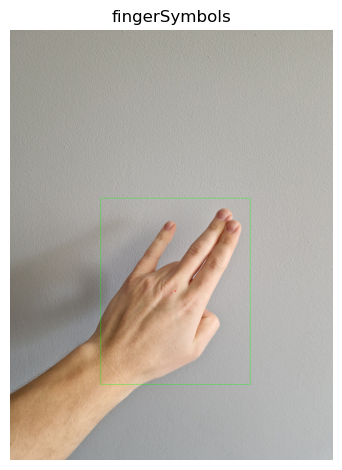

Center of hand: (1536, 2429)
Confidence: 0.6824


In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import mediapipe as mp
from fastai.vision.all import *
from PIL import Image
from fastai.vision.utils import show_image
from torchvision.models import densenet121
from pathlib import Path
from sklearn.metrics import f1_score
from fastprogress.fastprogress import force_console_behavior
from fastai.learner import Learner

# Clear any cached GPU memory
torch.cuda.empty_cache()

path = Path('data')

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=GrandparentSplitter(train_name='train', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[Resize(224, method='pad', pad_mode='zeros')],
)

dls = dblock.dataloaders(path, bs=32)

learn = vision_learner(
    dls,
    densenet121,
    metrics=error_rate,
    pretrained=True
)

learn.load('best-densenet-finetuned', with_opt=False)

# Custom image predictions
for test_img_path in ['20250406_135604.jpg', '20250406_135614.jpg', '20250406_135846.jpg']:
    test_img_path_full = f"do_rozpoznania/{test_img_path}"
    test_img = PILImage.create(test_img_path_full)

    # Read the image using OpenCV
    img = cv2.imread(test_img_path_full)  # BGR format
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    h, w, _ = img.shape

    # Resize the test image to match the model input size
    resize = Resize(224, method='pad', pad_mode='zeros')
    resized_img = resize(test_img)

    # Predict the label for the image
    pred_label, _, probs = learn.predict(PILImage.create(resized_img))

    # Initialize MediaPipe Hands for hand detection
    mp_hands = mp.solutions.hands.Hands(
        static_image_mode=True,
        max_num_hands=1,
        min_detection_confidence=0.5
    )

    # Process the image with MediaPipe Hands
    results = mp_hands.process(img_rgb)


    if results.multi_hand_landmarks:
        hand_landmarks = results.multi_hand_landmarks[0].landmark

        # Get all landmark coordinates (scaled to image size)
        xs = [int(lm.x * w) for lm in hand_landmarks]
        ys = [int(lm.y * h) for lm in hand_landmarks]

        # Calculate bounding box corners
        x1, x2 = min(xs), max(xs)
        y1, y2 = min(ys), max(ys)

        # Expand box a bit (optional)
        margin = int(0.1 * max(x2 - x1, y2 - y1))
        x1, y1 = max(0, x1 - margin), max(0, y1 - margin)
        x2, y2 = min(w, x2 + margin), min(h, y2 + margin)

        # Draw bounding box around the hand
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Calculate and draw center
        cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
        cv2.circle(img, (cx, cy), 5, (0, 0, 255), -1)

        # Show the image
        plt.close('all')
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(pred_label)
        plt.tight_layout()
        plt.show()

        print(f"Center of hand: ({cx}, {cy})")
    else:
        print("No hand detected.")

    print(f"Confidence: {probs.max():.4f}")

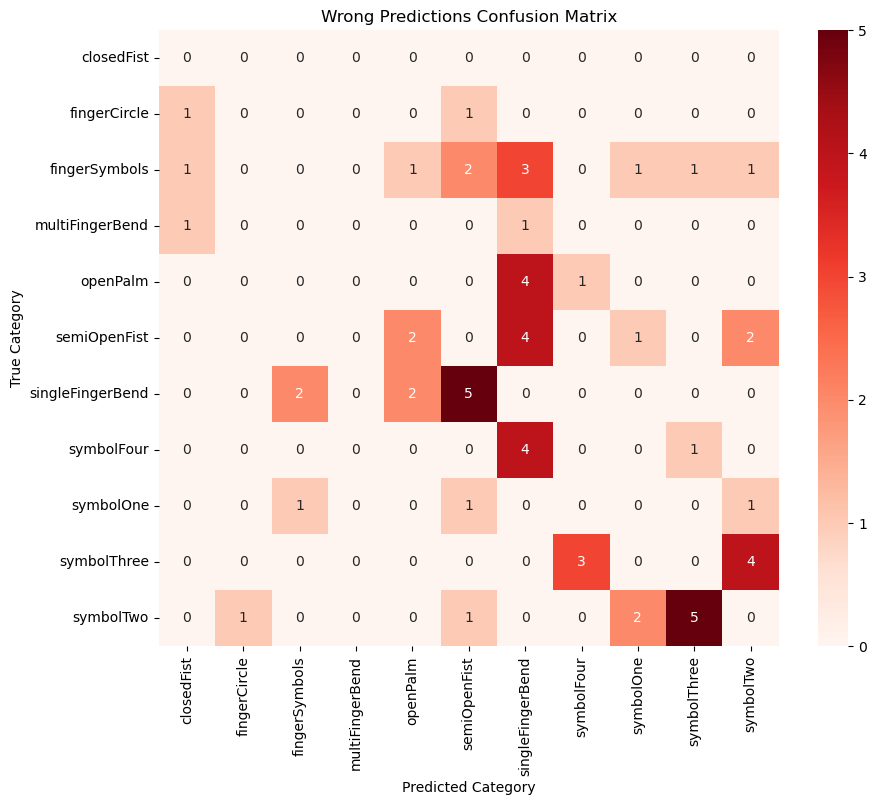

Macro F1 Score: 0.8555
Total wrong predictions: 61


In [6]:
# Create directory for wrong predictions
wrong_dir = Path('data/wrong_predicts')
wrong_dir.mkdir(exist_ok=True)

# Clear wrong_predicts directory
for f in wrong_dir.iterdir():
    if f.is_file():
        f.unlink()

class_names = dls.vocab
wrong_conf_matrix = pd.DataFrame(0, index=class_names, columns=class_names)
wrong_conf_value = 0

# Collect true and predicted labels for all images
y_true = []
y_pred = []

imgs = get_image_files(path/'valid')

# Save wrong predictions
with learn.no_bar():
    for img_path in imgs:
        img = PILImage.create(img_path)
        pred_label, _, probs = learn.predict(img)
        true_label = img_path.parent.name
        if str(pred_label) != true_label:
            save_name = f"{pred_label}_{true_label}_{img_path.name}"
            img.save(wrong_dir / save_name)
            wrong_conf_matrix.loc[true_label, str(pred_label)] += 1
            wrong_conf_value += 1    
        y_true.append(true_label)
        y_pred.append(str(pred_label))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(wrong_conf_matrix, annot=True, fmt="d", cmap="Reds")
plt.xlabel("Predicted Category")
plt.ylabel("True Category")
plt.title("Wrong Predictions Confusion Matrix")
plt.show()

f1 = f1_score(y_true, y_pred, average='macro', labels=class_names)
print(f"Macro F1 Score: {f1:.4f}")
print(f"Total wrong predictions: {wrong_conf_value}")